In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Add the PowerFactory Python API to the path
sys.path.append("C:/Program Files/DIgSILENT/PowerFactory 2024 SP4A/Python/3.12")

# Add the src directory to Python path for development
sys.path.append(os.path.join(os.getcwd(), "..")) 

import powerfactory as pf
from src.pfapi.core.Network import Network
from src.pfapi.utils.PFHelpers import init_project
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Initialize PowerFactory application and import 39-bus system model for this example
print("Initializing PowerFactory application...")
app: pf.Application = pf.GetApplicationExt()
app.Show()
init_project(app, "MAGISTRSKA\\Meshed Network MAG 25 EDIT")

Initializing PowerFactory application...
Successfully activated project: Meshed Network MAG 25 EDIT


In [40]:
# Initialize the Network object (reads topology and connected components)
try:
    app.Hide()  # Hide the PowerFactory GUI for cleaner output
    network = Network(app, base_mva=100.0)
except Exception as e:
    print("Failed to initialize the network. Ensure that the PowerFactory model is loaded correctly.")
    print(e)
    app.Show()  # Show the GUI again if initialization fails
app.Show()

# Obtain network admittance matrix
from src.pfapi.utils.AdmittanceMatrix import build_admittance_matrix
import pandas as pd
Y_bus = build_admittance_matrix(network, as_dataframe=True)
# Y_bus.head() # type: ignore

INFO: Processed 25 valid busbars
INFO: Running load flow analysis to obtain busbar results...
INFO: Reading network elements from PowerFactory...
INFO: Successfully read 90 classified elements from PF
INFO: Classified element counts:
INFO:   ElmLne: 40
INFO:   ElmLod: 25
INFO:   ElmSym: 25


In [ ]:
from src.pfapi.utils.AdmittanceMatrix import reduce_matrix
import numpy as np
import pandas as pd

# Reduce the admittance matrix to only generator buses
Y_bus = build_admittance_matrix(network, as_dataframe=False)
if not isinstance(Y_bus, np.ndarray):
    raise TypeError("Y_bus must be a numpy ndarray, but got type {}".format(type(Y_bus)))
reduced_Y_bus, generator_bus_names_order = reduce_matrix(Y_bus, network)

# Convert generator_bus_names to generator_names order
generator_names_order = [network.get_generator_name_from_busbar(bus) for bus in generator_bus_names_order]

# Display the reduced admittance matrix as a DataFrame for better readability
reduced_Y_bus_df = pd.DataFrame(reduced_Y_bus, index=generator_bus_names_order, columns=generator_bus_names_order)
reduced_Y_bus_df.head()

In [42]:
from src.pfapi.core.synchro_power_coefficients import calculate_power_distribution_ratios

# Calculate synchronizing power coefficients
GEN_OUT = "SG 33" # Define the generator name where outage occurs
ratios = calculate_power_distribution_ratios(reduced_Y_bus, generator_bus_names_order, network, GEN_OUT)
    
# Display the synchronizing power coefficients
# print(f"Synchronizing power coefficients for outage of generator {GEN_OUT}:")
# print(ratios)

INFO: Calculating synchronizing power coefficients for disturbance bus: Bus 33 at index 12


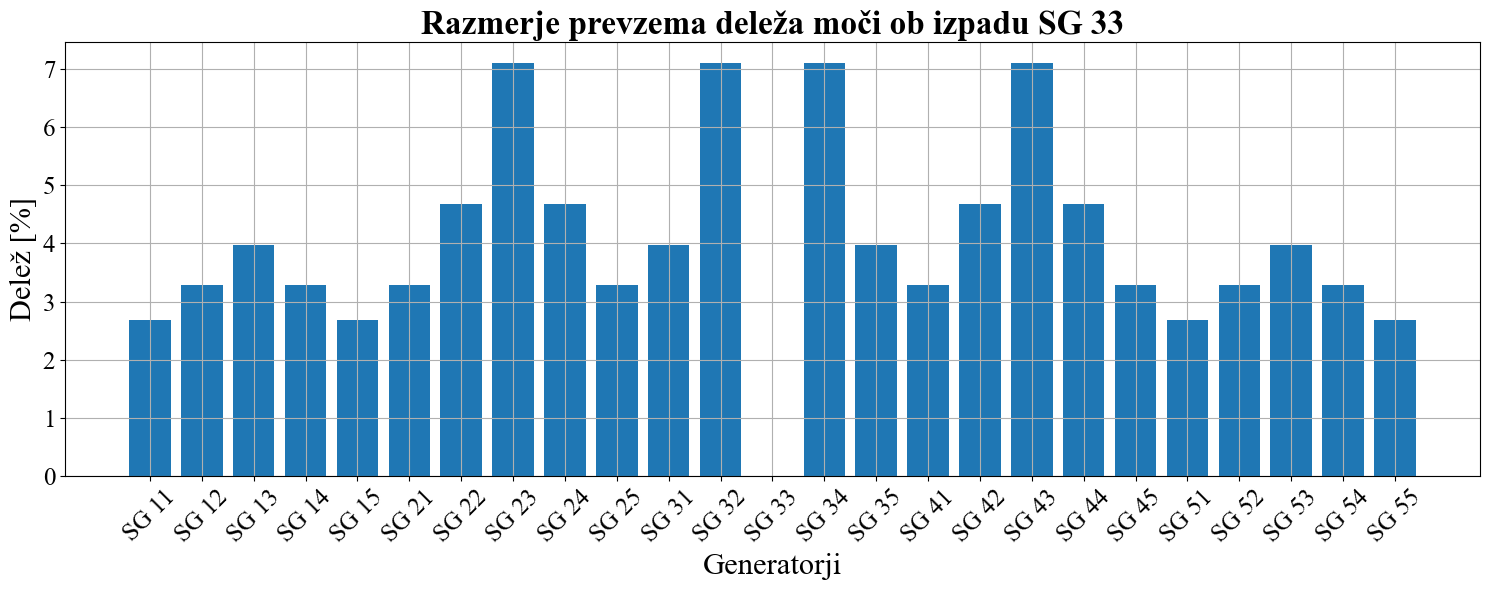

In [43]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'  # Embed fonts as text, not paths

plt.figure(figsize=(15, 6))
plt.bar(generator_names_order, ratios * 100)
plt.xlabel('Generatorji', fontsize=22, fontname='Times New Roman')
plt.ylabel('Delež [%]', fontsize=22, fontname='Times New Roman')
plt.title('Razmerje prevzema deleža moči ob izpadu {}'.format(GEN_OUT), fontsize=24, fontname='Times New Roman', fontweight='bold')
plt.xticks(rotation=45, fontsize=18, fontname='Times New Roman')
plt.yticks(fontsize=18, fontname='Times New Roman')
plt.grid(True)
plt.tight_layout()
plt.show()

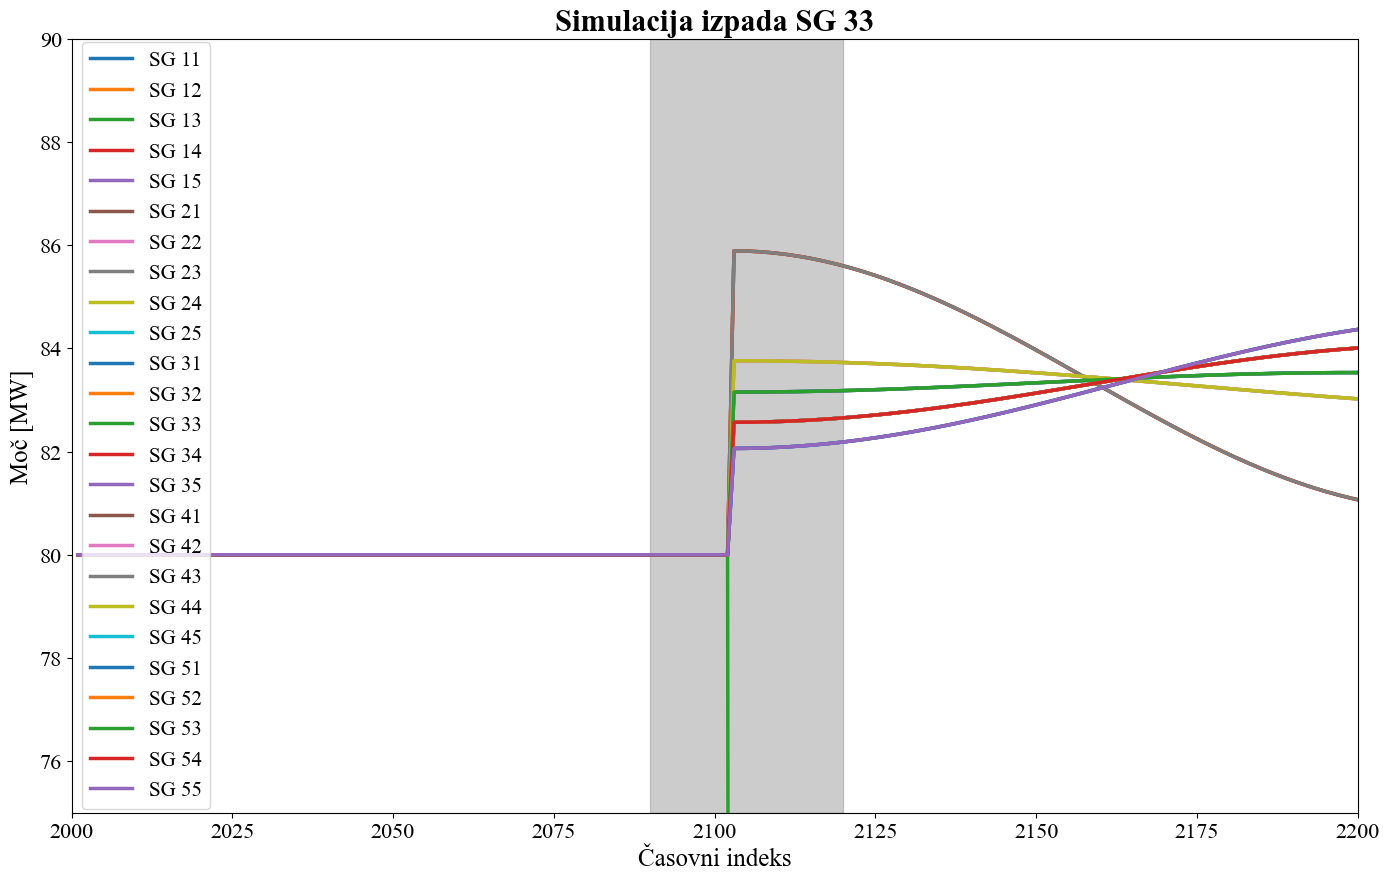

In [44]:
import matplotlib.pyplot as plt
from get_simulation_data import get_simulation_data

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Get the simulation data
rdP, simulation_gen_order, data = get_simulation_data(GEN_OUT, f"./rms_sim_results/results_izpad_{GEN_OUT}.csv")

plt.figure(figsize=(14, 9))
for i, gen in enumerate(generator_names_order):
    plt.plot(data[gen][2000:2200], label=gen, linewidth=2.5)
plt.xlabel('Časovni indeks', fontsize=18, fontname='Times New Roman')
plt.ylabel('Moč [MW]', fontsize=18, fontname='Times New Roman')
plt.title(f'Simulacija izpada {GEN_OUT}', fontsize=22, fontname='Times New Roman', fontweight='bold')
plt.ylim(75, 90)
plt.xlim(2000, 2200)

plt.legend(fontsize=15, loc='center left')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid(False)
plt.tight_layout()

# Mark area from 2090 to 2120 in gray
plt.axvspan(2090, 2120, color='gray', alpha=0.4)

# Save as SVG with high quality settings
plt.savefig('slike/simulation_plot.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)
plt.show()

In [45]:
import numpy as np
from sklearn.cluster import KMeans
from collections import defaultdict

def group_generators_by_ratios(ratios, generator_names, n_groups=5, tolerance=1e-4):
    """
    Group generators by similar ratio values.
    
    Parameters:
    - ratios: array of ratio values
    - generator_names: list of generator names
    - n_groups: number of groups to create
    - tolerance: tolerance for considering values as similar
    
    Returns:
    - groups: list of lists containing generator names for each group
    """
    
    # Method 1: Using KMeans clustering
    ratios_reshaped = ratios.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_groups, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(ratios_reshaped)
    
    # Group generators by cluster
    groups_kmeans = [[] for _ in range(n_groups)]
    for i, label in enumerate(cluster_labels):
        groups_kmeans[label].append(generator_names[i])
    
    # Sort groups by average ratio value
    group_avg_ratios = []
    for group_idx in range(n_groups):
        group_indices = [i for i, label in enumerate(cluster_labels) if label == group_idx]
        avg_ratio = np.mean([ratios[i] for i in group_indices])
        group_avg_ratios.append((group_idx, avg_ratio))
    
    # Sort by average ratio
    group_avg_ratios.sort(key=lambda x: x[1])
    
    # Reorder groups
    groups_sorted = []
    for group_idx, _ in group_avg_ratios:
        groups_sorted.append(groups_kmeans[group_idx])
    
    return groups_sorted, kmeans.cluster_centers_.flatten()

def group_generators_by_unique_values(ratios, generator_names, tolerance=1e-4):
    """
    Alternative method: Group by unique values within tolerance.
    """
    unique_groups = defaultdict(list)
    
    for i, ratio in enumerate(ratios):
        # Find if this ratio matches any existing group
        matched = False
        for unique_ratio in unique_groups.keys():
            if abs(ratio - unique_ratio) < tolerance:
                unique_groups[unique_ratio].append(generator_names[i])
                matched = True
                break
        
        if not matched:
            unique_groups[ratio].append(generator_names[i])
    
    # Convert to sorted list of groups
    sorted_groups = []
    for ratio in sorted(unique_groups.keys()):
        sorted_groups.append(unique_groups[ratio])
    
    return sorted_groups

# Apply grouping
print("Original ratios:", ratios)
print("Generator names:", generator_names_order)

# Method 1: KMeans clustering
groups_kmeans, cluster_centers = group_generators_by_ratios(ratios, generator_names_order, n_groups=5)
print("KMeans Clustering Groups:")
for i, group in enumerate(groups_kmeans):
    avg_ratio = cluster_centers[len(groups_kmeans) - 1 - i] if i < len(cluster_centers) else 0
    print(f"Group {i+1} (avg ratio: {cluster_centers[i]:.4f}): {group}")
print()

# Method 2: Unique values grouping
groups_unique = group_generators_by_unique_values(ratios, generator_names_order, tolerance=1e-4)
print("Unique Values Groups:")
for i, group in enumerate(groups_unique):
    # Calculate average ratio for this group
    group_indices = [generator_names_order.index(gen) for gen in group]
    avg_ratio = np.mean([ratios[idx] for idx in group_indices])
    print(f"Group {i+1} (avg ratio: {avg_ratio:.4f}): {group}")

Original ratios: [0.02680467 0.03284661 0.03968774 0.03284661 0.02680467 0.03284661
 0.04676238 0.071052   0.04676238 0.03284661 0.03968774 0.071052
 0.         0.071052   0.03968774 0.03284661 0.04676238 0.071052
 0.04676238 0.03284661 0.02680467 0.03284661 0.03968774 0.03284661
 0.02680467]
Generator names: ['SG 11', 'SG 12', 'SG 13', 'SG 14', 'SG 15', 'SG 21', 'SG 22', 'SG 23', 'SG 24', 'SG 25', 'SG 31', 'SG 32', 'SG 33', 'SG 34', 'SG 35', 'SG 41', 'SG 42', 'SG 43', 'SG 44', 'SG 45', 'SG 51', 'SG 52', 'SG 53', 'SG 54', 'SG 55']
KMeans Clustering Groups:
Group 1 (avg ratio: 0.0308): ['SG 33']
Group 2 (avg ratio: 0.0711): ['SG 11', 'SG 12', 'SG 14', 'SG 15', 'SG 21', 'SG 25', 'SG 41', 'SG 45', 'SG 51', 'SG 52', 'SG 54', 'SG 55']
Group 3 (avg ratio: 0.0468): ['SG 13', 'SG 31', 'SG 35', 'SG 53']
Group 4 (avg ratio: 0.0000): ['SG 22', 'SG 24', 'SG 42', 'SG 44']
Group 5 (avg ratio: 0.0397): ['SG 23', 'SG 32', 'SG 34', 'SG 43']

Unique Values Groups:
Group 1 (avg ratio: 0.0000): ['SG 33']


Merged generator order: ['SG 43', 'SG 34', 'SG 32', 'SG 23', 'SG 44', 'SG 42', 'SG 24', 'SG 22', 'SG 53', 'SG 35', 'SG 31', 'SG 13', 'SG 54', 'SG 52', 'SG 45', 'SG 41', 'SG 25', 'SG 21', 'SG 14', 'SG 12', 'SG 55', 'SG 51', 'SG 15', 'SG 11']
Merged ratios: [0.071052   0.071052   0.071052   0.071052   0.04676238 0.04676238
 0.04676238 0.04676238 0.03968774 0.03968774 0.03968774 0.03968774
 0.03284661 0.03284661 0.03284661 0.03284661 0.03284661 0.03284661
 0.03284661 0.03284661 0.02680467 0.02680467 0.02680467 0.02680467]
Reversed groups for plotting: [['SG 23', 'SG 32', 'SG 34', 'SG 43'], ['SG 22', 'SG 24', 'SG 42', 'SG 44'], ['SG 13', 'SG 31', 'SG 35', 'SG 53'], ['SG 12', 'SG 14', 'SG 21', 'SG 25', 'SG 41', 'SG 45', 'SG 52', 'SG 54'], ['SG 11', 'SG 15', 'SG 51', 'SG 55']]
Bar colors for plotting: ['#E81313', '#E81313', '#E81313', '#E81313', '#FE7070', '#FE7070', '#FE7070', '#FE7070', '#FC9432', '#FC9432', '#FC9432', '#FC9432', '#FFE342', '#FFE342', '#FFE342', '#FFE342', '#FFE342', '#FFE

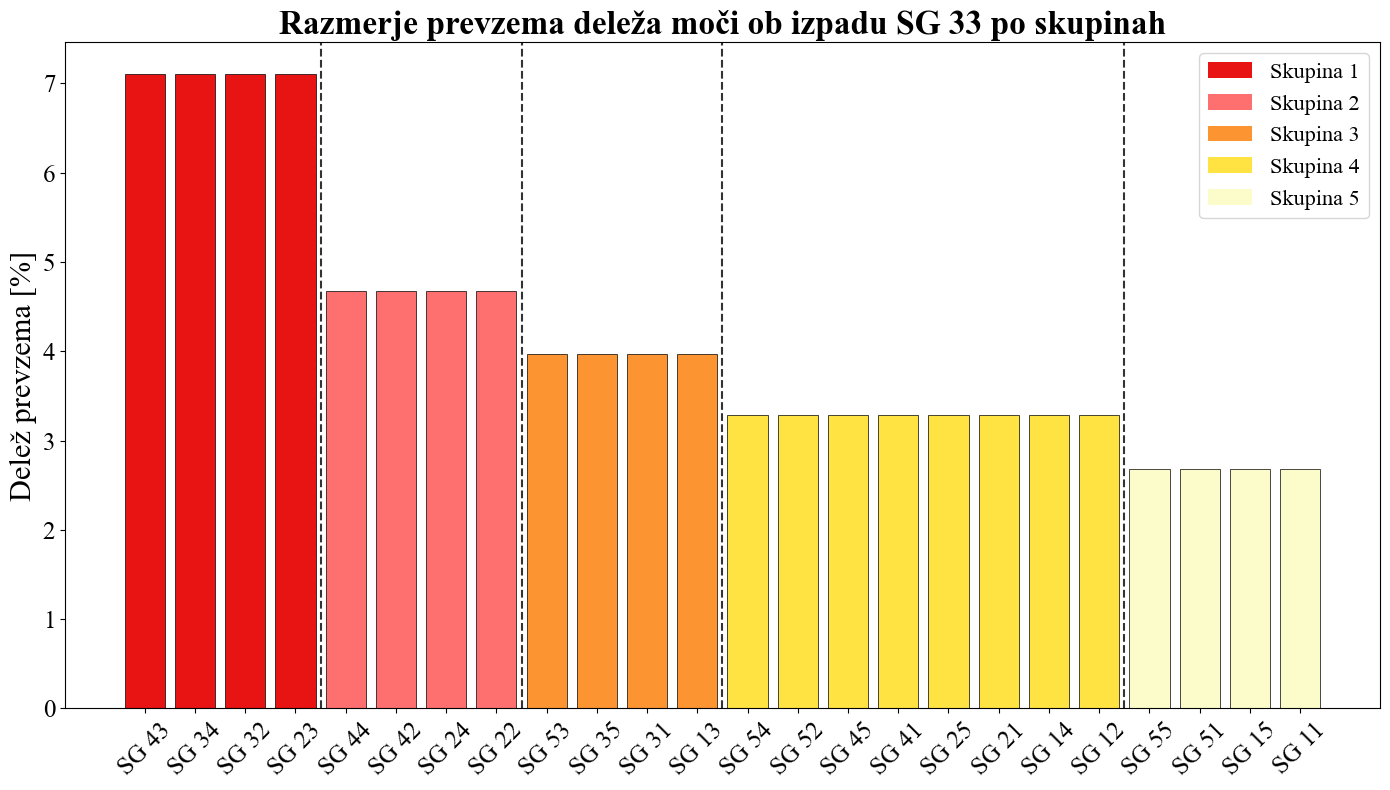

In [46]:
# Merge all groups into one ordered list
merged_groups = []
for group in groups_unique:
    merged_groups.extend(group)
merged_groups.pop(0) # Remove first group since its outage generator SG 33
# Reverse the merged_groups list
merged_groups = merged_groups[::-1]
print("Merged generator order:", merged_groups)

# Get ratios in the new merged order
merged_ratios = []
for gen in merged_groups:
    # Find the index of this generator in the original order
    original_index = generator_names_order.index(gen)
    merged_ratios.append(ratios[original_index])
merged_ratios = np.array(merged_ratios)
print ("Merged ratios:", merged_ratios)

# Use default MATLAB colors
group_colors = ['#E81313', "#FE7070", '#FC9432', '#FFE342', '#FCFCCA']

# Reverse the order of groups for plotting
groups_unique_reversed = groups_unique[::-1]
# Remove the last group from the reversed groups for plotting
groups_unique_reversed = groups_unique_reversed[:-1]
print("Reversed groups for plotting:", groups_unique_reversed)

# Create color array for bars
bar_colors = []
for i, group in enumerate(groups_unique_reversed):
    bar_colors.extend([group_colors[i % len(group_colors)]] * len(group))
print("Bar colors for plotting:", bar_colors)

plt.figure(figsize=(14, 8))
bars = plt.bar(merged_groups, merged_ratios * 100, color=bar_colors, edgecolor='black', linewidth=0.5)
plt.xlabel(xlabel='', fontsize=22, fontname='Times New Roman')
plt.ylabel('Delež prevzema [%]', fontsize=22, fontname='Times New Roman')
plt.title('Razmerje prevzema deleža moči ob izpadu {} po skupinah'.format(GEN_OUT), fontsize=24, fontname='Times New Roman', fontweight='bold')
plt.xticks(rotation=45, fontsize=18, fontname='Times New Roman')
plt.yticks(fontsize=18, fontname='Times New Roman')
# plt.grid(True, alpha=0.3, axis='y')
plt.grid(False)
plt.tight_layout()

# Add group separators with thicker lines
group_starts = [0]
for group in groups_unique_reversed[:-1]:
    group_starts.append(group_starts[-1] + len(group))

# Add vertical lines to separate groups
for start in group_starts[1:]:
    plt.axvline(x=start-0.5, color='black', linestyle='--', alpha=0.8, linewidth=1.5)

# Create custom legend for groups
legend_handles = []
for i, group in enumerate(groups_unique_reversed):
    group_indices = [generator_names_order.index(gen) for gen in group]
    avg_ratio = np.mean([ratios[idx] for idx in group_indices])
    legend_handles.append(plt.Rectangle((0,0),1,1, facecolor=group_colors[i % len(group_colors)], 
                                      label=f'Skupina {i+1}'))
plt.legend(handles=legend_handles, loc='upper right', fontsize=16)

# Save as SVG
plt.savefig('slike/grouped_ratios_plot_colored.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)

plt.show()

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from src.pfapi.core.synchro_power_coefficients import calculate_for_multiple_outages

# Create the power distribution matrix using all generator outages
app.Hide()
coefficients, gen_order = calculate_for_multiple_outages(reduced_Y_bus, generator_bus_names_order, network, generator_names_order)
# coefficients = np.array(coefficients) # Convert to numpy array
app.Show()

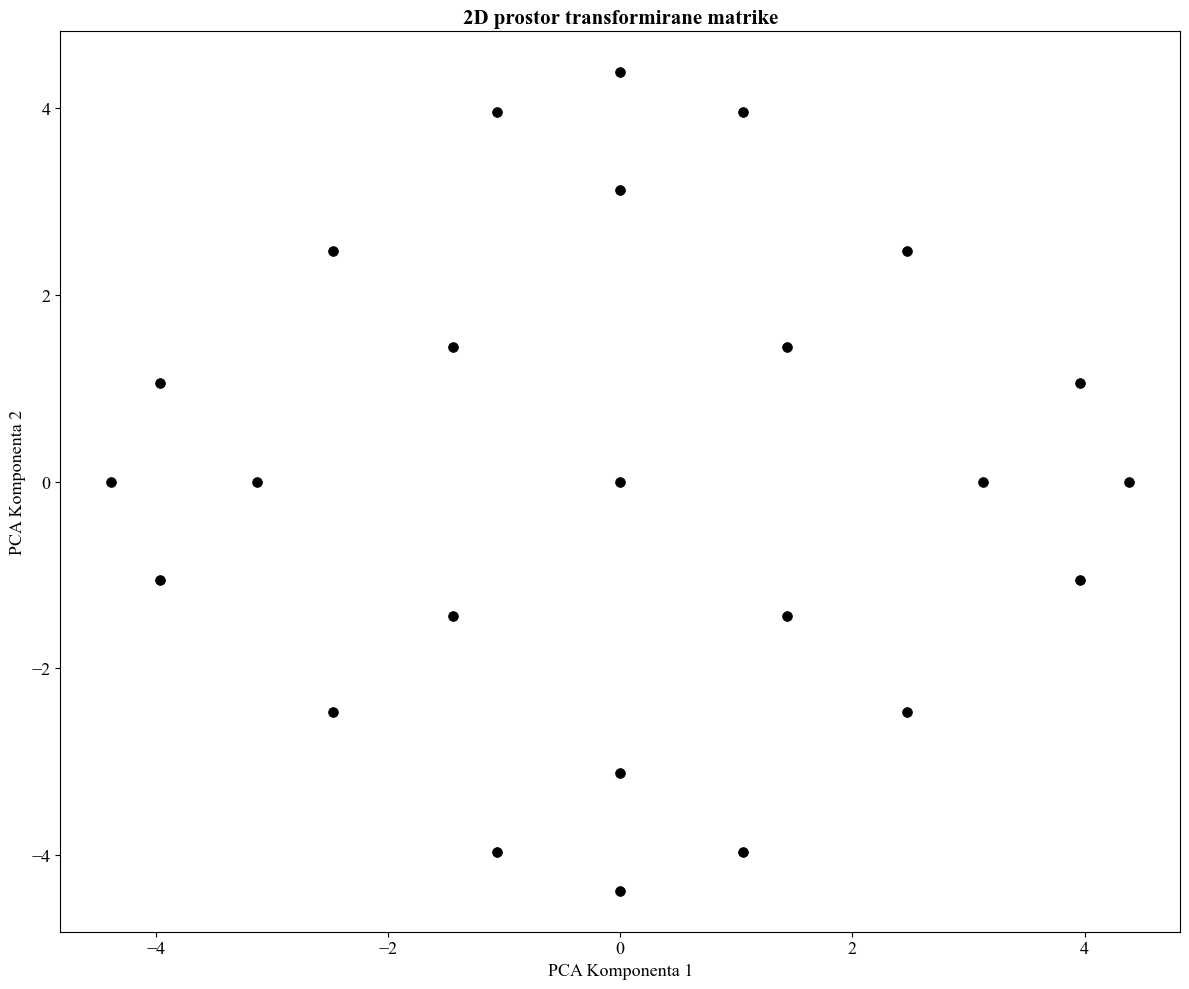

PCA komponenta 1 razloži 25.26% variance
PCA komponenta 2 razloži 25.26% variance
Skupaj razloženo: 50.53%


In [48]:
# Apply PCA to reduce to 2D with standardization
from sklearn.preprocessing import StandardScaler

# Standardize the data before PCA
scaler = StandardScaler()
coefficients_np = np.array(coefficients)
coefficients_scaled = scaler.fit_transform(coefficients_np)

# Apply PCA to the standardized data
pca = PCA(n_components=2)
power_distribution_matrix_transformed = pca.fit_transform(coefficients_scaled)

# Visualize the 2D plot of the transformed power distribution matrix
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(power_distribution_matrix_transformed[:, 0], power_distribution_matrix_transformed[:, 1], 
                    color='black', s=50, edgecolors='black', linewidth=0.5)
# for i, txt in enumerate(gen_order):
#     ax.annotate(txt, (power_distribution_matrix_transformed[i, 0] + 0.01, power_distribution_matrix_transformed[i, 1]), 
#                fontsize=13)

ax.set_xlabel('PCA Komponenta 1', fontsize=13)
ax.set_ylabel('PCA Komponenta 2', fontsize=13)
ax.set_title('2D prostor transformirane matrike', fontsize=15, fontweight='bold')
ax.tick_params(labelsize=13)
# ax.set_xlim(-0.4, 0.4)
# ax.set_ylim(-0.4, 0.4)
ax.grid(False)
plt.tight_layout()

# Save with specific parameters for crisp rendering
plt.savefig('slike/pca_2d_plot.svg', format='svg', bbox_inches='tight',
           facecolor='white', edgecolor='none', transparent=False)

plt.show()

# Print PCA explained variance ratio
print(f"PCA komponenta 1 razloži {pca.explained_variance_ratio_[0]:.2%} variance")
print(f"PCA komponenta 2 razloži {pca.explained_variance_ratio_[1]:.2%} variance")
print(f"Skupaj razloženo: {sum(pca.explained_variance_ratio_):.2%}")

[2.57589105 3.20973901 3.9411555  3.20973901 2.57589105 3.20973901
 4.70027295 7.36320249 4.70027295 3.20973901 3.9411555  7.36320249
 0.         7.36320249 3.9411555  3.20973901 4.70027295 7.36320249
 4.70027295 3.20973901 2.57589105 3.20973901 3.9411555  3.20973901
 2.57589105]
[0.02680467 0.03284661 0.03968774 0.03284661 0.02680467 0.03284661
 0.04676238 0.071052   0.04676238 0.03284661 0.03968774 0.071052
 0.         0.071052   0.03968774 0.03284661 0.04676238 0.071052
 0.04676238 0.03284661 0.02680467 0.03284661 0.03968774 0.03284661
 0.02680467]
The new disturbance fits the most with generator index 12
SG 33


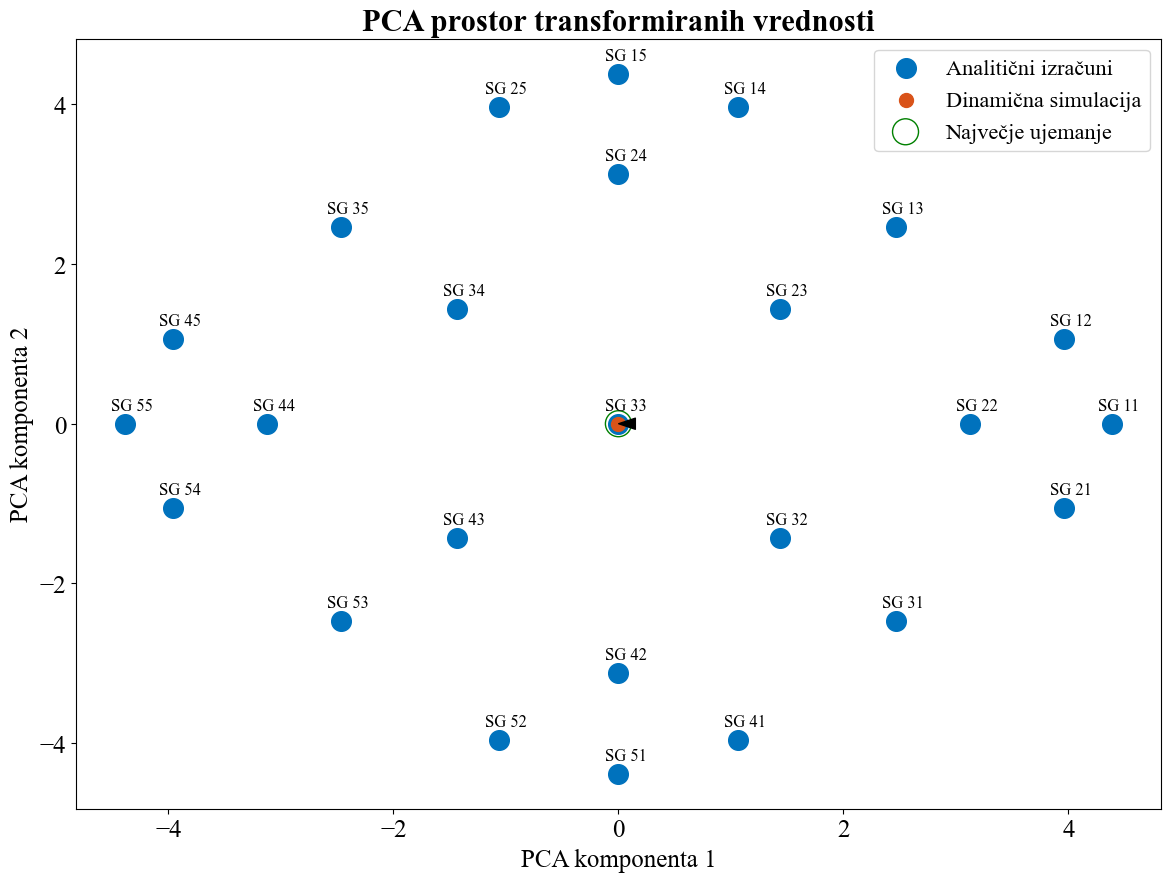

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from get_simulation_data import get_simulation_data

# Reorder rdP to match gen_order
rdP_reordered = []
for gen in generator_names_order:
    # Find the index of this generator in simulation_gen_order
    sim_index = simulation_gen_order.index(gen)
    # Add the corresponding rdP value
    rdP_reordered.append(rdP[sim_index])

# Convert back to numpy array if needed
rdP_reordered = np.array(rdP_reordered)

print(rdP_reordered)
print(ratios)

# Prepare data for PCA
sim_disturbance = np.array(np.array(rdP_reordered) / 100)
# Apply the same standardization as used for the training data
sim_disturbance_scaled = scaler.transform(sim_disturbance.reshape(1, -1))
new_disturbance_transformed = pca.transform(sim_disturbance_scaled)  # Transform the new disturbance

# Calculate Euclidean distances
distances = euclidean_distances(new_disturbance_transformed, power_distribution_matrix_transformed).flatten()

# Find the index of the minimum distance
best_fit_index = np.argmin(distances)

print(f"The new disturbance fits the most with generator index {best_fit_index}")
print(gen_order[best_fit_index])

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Plot PCA Scatter
plt.figure(figsize=(14, 10))
plt.scatter(power_distribution_matrix_transformed[:, 0], power_distribution_matrix_transformed[:, 1], color='#0072BD', label='Analitični izračuni', s=200)
plt.scatter(new_disturbance_transformed[:, 0], new_disturbance_transformed[:, 1], color='#D95319', label='Dinamična simulacija', s=100)
# Draw a green circle around the best match
plt.scatter(power_distribution_matrix_transformed[best_fit_index, 0], power_distribution_matrix_transformed[best_fit_index, 1], 
            color='green', label='Največje ujemanje', marker='o', s=350, facecolors='none')

# Add an arrow annotation pointing to the best match point
plt.annotate('', 
            xy=(power_distribution_matrix_transformed[best_fit_index, 0], power_distribution_matrix_transformed[best_fit_index, 1]),
            xytext=(power_distribution_matrix_transformed[best_fit_index, 0] + 0.05, power_distribution_matrix_transformed[best_fit_index, 1]),
            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8),
            fontsize=10)

for i, txt in enumerate(gen_order):
    plt.annotate('SG '+txt[3:], (power_distribution_matrix_transformed[i, 0], power_distribution_matrix_transformed[i, 1]), 
                xytext=(-10, 10), textcoords='offset points', fontsize=12)
    
plt.xlabel('PCA komponenta 1', fontsize=18)
plt.ylabel('PCA komponenta 2', fontsize=18)
plt.title('PCA prostor transformiranih vrednosti', fontsize=22, fontweight='bold')
plt.legend(loc='upper right', fontsize=16)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.xlim(-0.4, 0.4)
# plt.ylim(-0.4, 0.4)
plt.savefig('slike/pca_disturbance_match.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)
plt.show()


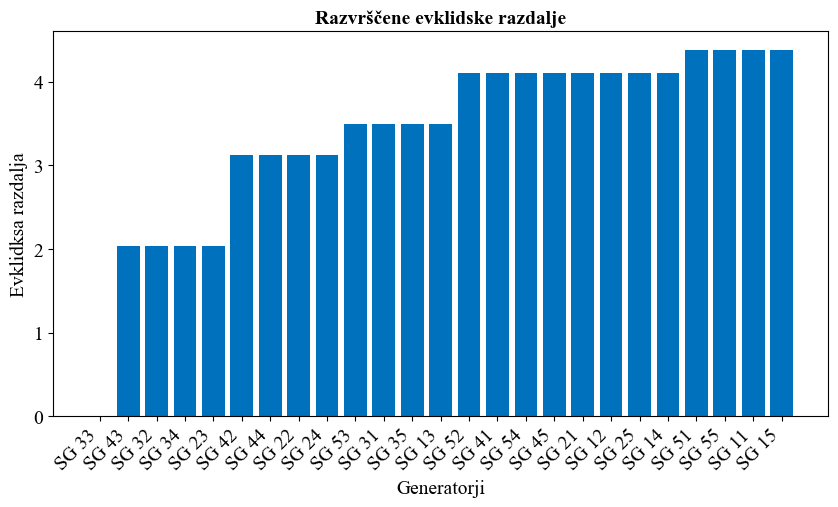

In [50]:
# BAR CHART: Sort distances from lowest to highest
sorted_indices = np.argsort(distances)
sorted_distances = distances[sorted_indices]
sorted_generators = [gen_order[i] for i in sorted_indices]  # Sort generator labels accordingly

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_distances)), sorted_distances, color='#0072BD')
plt.xticks(range(len(sorted_generators)), sorted_generators, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Generatorji", fontsize=14)
plt.ylabel("Evklidksa razdalja", fontsize=14)
plt.title("Razvrščene evklidske razdalje", fontsize=14, fontweight='bold')
plt.savefig('slike/pca_disturbance_match.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)
plt.show()

[3.20973901 3.9411555  3.20973901 2.57589105 2.57589105 3.20973901
 3.9411555  3.20973901 2.57589105 3.20973901 3.9411555  3.20973901
 2.57589105 3.20973901 3.20973901 3.9411555  4.70027295 7.36320249
 4.70027295 7.36320249 7.36320249 4.70027295 7.36320249 4.70027295
 0.        ]


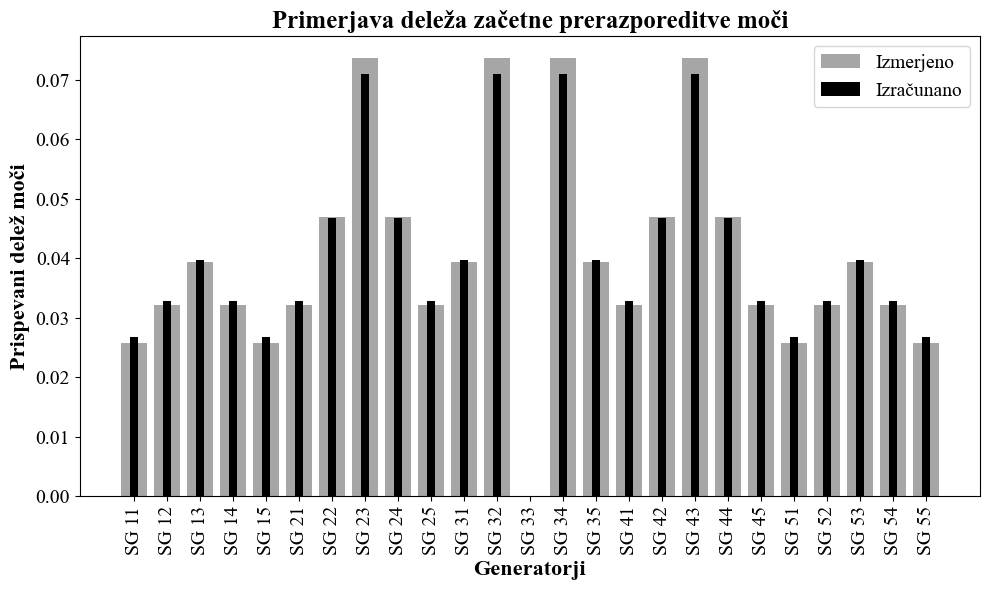

In [51]:
# Plot the synched_simulation_data values
import matplotlib.pyplot as plt

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['svg.fonttype'] = 'none'  # Embed fonts as text, not paths

print(rdP)

# Reorder rdP to match gen_order
rdP_reordered = []
for gen in generator_names_order:
    # Find the index of this generator in simulation_gen_order
    sim_index = simulation_gen_order.index(gen)
    # print(simulation_gen_order.index(gen))
    # Add the corresponding rdP value
    rdP_reordered.append(rdP[sim_index])

# Convert back to numpy array if needed
rdP_reordered = np.array(rdP_reordered)

plt.figure(figsize=(10, 6))
# gen_names = ["G1", "G3", "G4", "G0", "G2"]
bar2 = plt.bar(gen_order, rdP_reordered/100, 0.8, color='gray', label='Izmerjeno', alpha=0.7)
bar1 = plt.bar(gen_order, ratios, 0.25, color='black', label='Izračunano', alpha=1)
plt.xlabel('Generatorji', fontsize=16, fontweight='bold')
plt.ylabel('Prispevani delež moči', fontsize=16, fontweight='bold')
plt.title('Primerjava deleža začetne prerazporeditve moči', fontsize=18, fontweight='bold')
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(fontsize=14)
plt.tight_layout()

# Save as SVG with high quality settings
plt.savefig('slike/power_contribution_comparison.svg', format='svg', bbox_inches='tight', 
           facecolor='white', edgecolor='none', transparent=False)

plt.show()